In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepshare-playground-series2/sample_submission.csv
/kaggle/input/deepshare-playground-series2/train_data.csv
/kaggle/input/deepshare-playground-series2/test_data.csv


In [2]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import multiprocessing

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

# Course-2 主要内容
## 1.数据处理
* 数据读取
* 数据预处理
* Pandas 处理一列数据的逻辑(map/apply)

## 2.模型调用
* scikit-learn 经典模型使用
* lightgbm/xgboost/catboost 模型使用

## 3.模型验证
* hold out验证
* 交叉验证

# 1.数据处理

In [3]:
train_df = pd.read_csv('/kaggle/input/deepshare-playground-series2/train_data.csv')
test_df = pd.read_csv('/kaggle/input/deepshare-playground-series2/test_data.csv')

# label转成int32
train_df['label'] = train_df['label'].astype('int32')

In [4]:
# 把train&test拼在一起，方便后续的数据编码
df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)

In [5]:
df.head()

,label,user_id,item_id,item_fea1,user_fea1,user_fea2,user_fea3,user_fea4,lng,lat,user_fea5,ts,user_fea6,user_fea7,user_fea8,user_fea9,user_tag,ID
0,0.0,WgwGia5U3IS4BXkm,WORhuXJqpf4brDGS,2,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,3Xvgq4YJCV2DHb0o,wLQbAfi9agGtNj8M,108.664005,22.244352,W8b1IqPHxX9aGQYF,1573193245778,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",0
1,0.0,WgwGia5U3IS4BXkm,WORhuXJqpf4brDGS,2,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,3Xvgq4YJCV2DHb0o,wLQbAfi9agGtNj8M,108.664005,22.244352,W8b1IqPHxX9aGQYF,1573193245778,0.0,10.0,28.0,0.0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",1
2,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573300837960,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",2
3,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573300837960,0.0,10.0,28.0,0.0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",3
4,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573311745524,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",4


In [6]:
df.info(verbose=True,null_counts=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811458 entries, 0 to 5811457
Data columns (total 18 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   label      3530252 non-null  float64
 1   user_id    5811458 non-null  object 
 2   item_id    5811458 non-null  object 
 3   item_fea1  5811458 non-null  int64  
 4   user_fea1  5811458 non-null  object 
 5   user_fea2  5811458 non-null  object 
 6   user_fea3  5811458 non-null  object 
 7   user_fea4  5811458 non-null  object 
 8   lng        5811458 non-null  float64
 9   lat        5811458 non-null  float64
 10  user_fea5  5811458 non-null  object 
 11  ts         5811458 non-null  int64  
 12  user_fea6  4500899 non-null  float64
 13  user_fea7  4526101 non-null  float64
 14  user_fea8  4595001 non-null  float64
 15  user_fea9  3629886 non-null  float64
 16  user_tag   5811458 non-null  object 
 17  ID         5811458 non-null  int64  
dtypes: float64(7), int64(3), object(8)
memory 

In [7]:
num_cols  =  [f'user_fea{i}' for i in range(6,9)] 
cate_cols = ['user_id','item_id']+ [f'user_fea{i}' for i in range(1,6)] + ['item_fea1']+['user_fea9']

In [8]:
num_cols

['user_fea6', 'user_fea7', 'user_fea8']

In [9]:
print(cate_cols)

['user_id', 'item_id', 'user_fea1', 'user_fea2', 'user_fea3', 'user_fea4', 'user_fea5', 'item_fea1', 'user_fea9']


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

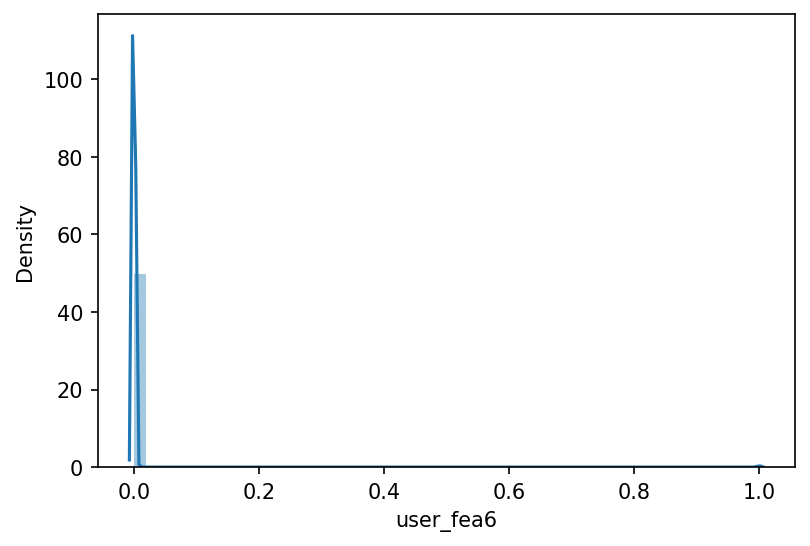

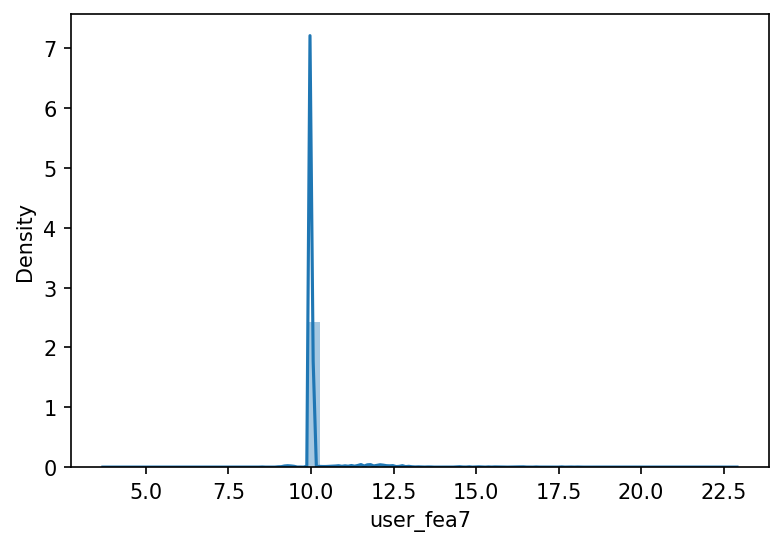

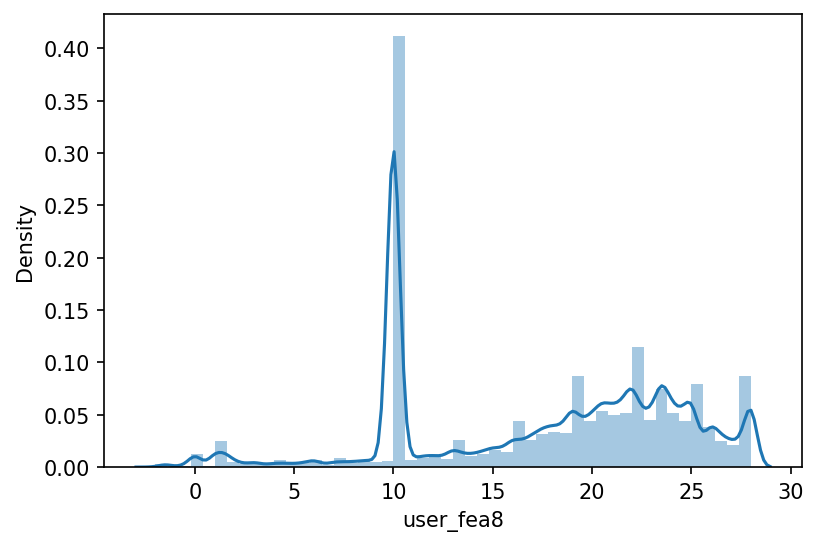

In [10]:
# 连续特征
for col in tqdm(num_cols):
    plt.figure(dpi=150)
    sns.distplot(df[col])

In [11]:
# 原生数据编码
for col in tqdm(num_cols):
    df[col] = df[col].fillna(0)
    # min-max
#     df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    # z-score
    df[col] = (df[col] - df[col].mean()) / df[col].std()

  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
# sklearn 数据编码
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])

# train_df[num_cols] = scaler.fit(train_df[num_cols])

# train_df[num_cols] = scaler.transform(train_df[num_cols])
# test_df[num_cols] = scaler.transform(test_df[num_cols])

In [13]:
# 离散特征
# for col in tqdm(['user_fea1', 'user_fea2', 'user_fea3', 'user_fea4', 'user_fea5', 'item_fea1', 'user_fea9']):
#     plt.figure(dpi=150)
#     sns.countplot(df[col])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

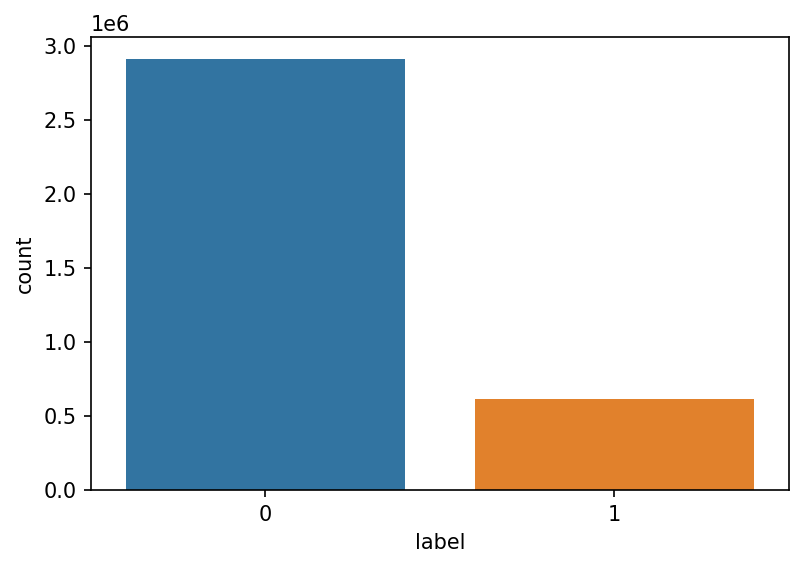

In [14]:
plt.figure(dpi=150)
sns.countplot(train_df['label'])

In [15]:
# 原生离散特征编码
# 操作df一列：
# 1.map方法：输入一个dict(k:v对)
# 2.apply方法：输入一个func,这个func的输入是该列特征的一个值，返回结果是修改后的值
for col in tqdm(cate_cols):
    df[col] = df[col].fillna('-1')
    map_dict = dict(zip(df[col].unique(), range(df[col].nunique())))
    
    df[col] = df[col].map(map_dict)
    df[f'{col}_count'] = df[col].map(df[col].value_counts())

  0%|          | 0/9 [00:00<?, ?it/s]

In [16]:
# 需要维护一个map_dict来定义映射的方法
map_dict = dict( zip( train_df['user_fea1'].unique(), range(train_df['user_fea1'].nunique()) ) )

In [17]:
def func1(x):
    return '666_'+x

In [18]:
train_df['user_fea1'].apply(func1)

0          666_KmsYcoDyQi7zprXT
1          666_KmsYcoDyQi7zprXT
2          666_KmsYcoDyQi7zprXT
3          666_KmsYcoDyQi7zprXT
4          666_KmsYcoDyQi7zprXT
                   ...         
3530247    666_J2lywfeYA6Cov3mu
3530248    666_J2lywfeYA6Cov3mu
3530249    666_J2lywfeYA6Cov3mu
3530250    666_J2lywfeYA6Cov3mu
3530251    666_J2lywfeYA6Cov3mu
Name: user_fea1, Length: 3530252, dtype: object

In [19]:
# sklearn 离散特征编码
# for col in tqdm(cate_cols):
#     scale = LabelEncoder()
#     scale.fit(df[col])
#     df[col] = scale.transform(df[col])

In [20]:
train_df = df[df['label'].notna()].reset_index(drop=True)
test_df = df[df['label'].isna()].reset_index(drop=True)

In [21]:
train_df.shape,test_df.shape

((3530252, 27), (2281206, 27))

In [22]:
drop_feature = ['ID','label','lng','lat','ts','user_tag']
feature = [x for x in train_df.columns if x not in drop_feature]
print(len(feature),feature)

21 ['user_id', 'item_id', 'item_fea1', 'user_fea1', 'user_fea2', 'user_fea3', 'user_fea4', 'user_fea5', 'user_fea6', 'user_fea7', 'user_fea8', 'user_fea9', 'user_id_count', 'item_id_count', 'user_fea1_count', 'user_fea2_count', 'user_fea3_count', 'user_fea4_count', 'user_fea5_count', 'item_fea1_count', 'user_fea9_count']


# 2.模型调用

In [23]:
### sklearn一般的范式
'''
# 实例化模型
model = XXX(**params)

# 拟合模型
model.fit(X_train, y_train)

# 模型预测 类别
model.predict(X_test)

# 输出概率(分类任务)
model.predict_proba(X_test)

# 获得这个模型的参数
model.get_params()
'''

'\n# 实例化模型\nmodel = XXX(**params)\n\n# 拟合模型\nmodel.fit(X_train, y_train)\n\n# 模型预测 类别\nmodel.predict(X_test)\n\n# 输出概率(分类任务)\nmodel.predict_proba(X_test)\n\n# 获得这个模型的参数\nmodel.get_params()\n'

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[feature], train_df['label'], random_state=666)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


model = AdaBoostClassifier()

model.fit(X_train, y_train)

y_valid_pre = model.predict_proba(X_valid)[:,1] 
# 二分类任务输出的维度是：nx2

print(f'{str(model)} AUC :{roc_auc_score(y_valid, y_valid_pre)}')

print(f'{str(model)} LogLoss :{log_loss(y_valid, y_valid_pre)}')

y_pre = model.predict_proba(test_df[feature])[:,1]

AdaBoostClassifier() AUC :0.8026027777302978
AdaBoostClassifier() LogLoss :0.6741827729451624


In [27]:
sklearn_sub_df = pd.DataFrame()
sklearn_sub_df['ID'] = test_df['ID']
sklearn_sub_df['label'] = y_pre
sklearn_sub_df.to_csv('/kaggle/working/sklearn_baseline.csv',index=False)

# 3.模型验证

In [28]:
params = {'num_leaves': 63, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'objective': 'binary', #定义的目标函数
          'max_depth': 8,
          'learning_rate': 0.1,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 1,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 1,
          "bagging_seed": 11,
#           "lambda_l1": 0.1,             #l1正则
          # 'lambda_l2': 0.001,     #l2正则
          "verbosity": -1,
          "nthread": multiprocessing.cpu_count(),                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2077, #随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

n_fold = 5
oof_pre = np.zeros(len(train_df))
y_pre = np.zeros(len(test_df))

kf = KFold(n_splits=n_fold)
for fold_, (trn_idx, val_idx) in enumerate(kf.split(train_df)):

    trn_data = lgb.Dataset(train_df[feature].iloc[trn_idx], label=train_df['label'].iloc[trn_idx])
    val_data = lgb.Dataset(train_df[feature].iloc[val_idx], label=train_df['label'].iloc[val_idx])

    clf = lgb.train(params,
                    trn_data,
                    2000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=50,
                    early_stopping_rounds=50)
    # out of fold
    oof_pre[val_idx] = clf.predict(train_df[feature].iloc[val_idx], num_iteration=clf.best_iteration)

    y_pre += clf.predict(test_df[feature], num_iteration=clf.best_iteration) / n_fold

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.348639	training's auc: 0.838277	valid_1's binary_logloss: 0.349025	valid_1's auc: 0.837033
[100]	training's binary_logloss: 0.331203	training's auc: 0.860295	valid_1's binary_logloss: 0.332585	valid_1's auc: 0.857857
[150]	training's binary_logloss: 0.321047	training's auc: 0.87198	valid_1's binary_logloss: 0.32339	valid_1's auc: 0.868531
[200]	training's binary_logloss: 0.314268	training's auc: 0.879236	valid_1's binary_logloss: 0.317532	valid_1's auc: 0.874852
[250]	training's binary_logloss: 0.308775	training's auc: 0.884856	valid_1's binary_logloss: 0.313005	valid_1's auc: 0.879511
[300]	training's binary_logloss: 0.303744	training's auc: 0.88972	valid_1's binary_logloss: 0.308831	valid_1's auc: 0.883609
[350]	training's binary_logloss: 0.299311	training's auc: 0.893728	valid_1's binary_logloss: 0.305362	valid_1's auc: 0.886766
[400]	training's binary_logloss: 0.295703	training's auc: 0.8

In [29]:
local_auc = roc_auc_score(train_df['label'], oof_pre)
print(f'Local AUC :{local_auc}')

Local AUC :0.9080201911806662


In [30]:
res_df = pd.DataFrame()
res_df['ID'] = test_df['ID']
res_df['label'] = y_pre
res_df.to_csv('/kaggle/working/lgb-baseline.csv',index=False)